Importing Necessary Packages

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

Data Analysing and Visualization

In [56]:
train_path = "C:\\Users\\th3tr\Pixel's Folder\\Programming\\Python\\Kaggle\\CODSOFT\\Genre Classification Dataset\\train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
genre_train = train_data.copy()

In [57]:
print(genre_train.describe())
print("#######################\n")
print(genre_train.info())
print("#######################\n")
print(genre_train.isnull().sum())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  
#######################

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
#######################

Title          0
Genre          0
Descrip

In [58]:
class_distribution = genre_train['Genre'].value_counts()
print(class_distribution)
imbalance_ratio = class_distribution.min() / class_distribution.max()
print("\nImbalance Ratio:", imbalance_ratio)

Genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

Imbalance Ratio: 0.009696613531183427


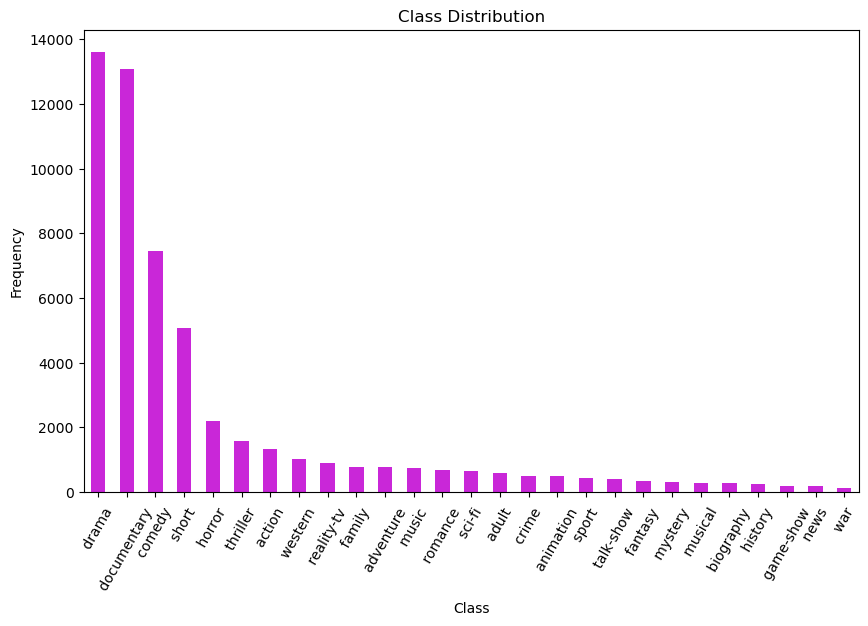

In [59]:
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='#c927d8')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

Data Preprocessing

In [60]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\th3tr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\th3tr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
stem = LancasterStemmer()
stp = set(stopwords.words("english"))

def remove_twitter_handles(text):
    return re.sub(r'@\S+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_pictures(text):
    return re.sub(r'pic.\S+', '', text)

def keep_only_characters(text):
    return re.sub(r"[^a-zA-Z+']", ' ', text)

def keep_words_length_greater_than_one(text):
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')

def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords_and_short_words(words):
    return [i for i in words if i not in stp and len(i) > 2]


In [62]:
def clean_text(text):
    text = text.lower()
    text = remove_twitter_handles(text)
    text = remove_urls(text)
    text = remove_pictures(text)
    text = keep_only_characters(text)
    text = keep_words_length_greater_than_one(text)
    text = remove_punctuation(text)
    words = tokenize(text)
    words = remove_stopwords_and_short_words(words)
    text = " ".join(words)
    text = re.sub("\s[\s]+", " ", text).strip()
    return text

In [63]:
genre_train['cleaned_text'] = genre_train['Description'].apply(clean_text)
genre_train

,Title,Genre,Description,cleaned_text
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...
...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,short lived nbc live sitcom centered bonino wo...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,next generation exploitation sisters kapa bay ...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",bestaan echt stand comedy growing facing fears...
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live country difficult time keep...


In [64]:
#Convert labels to numerical values for modeling
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
genre_train['Genre_encoded'] = label_encoder.fit_transform(genre_train['Genre'])
genre_train['Genre_encoded']

class_names= list(label_encoder.classes_)
class_names

genre_train.head(5)

,Title,Genre,Description,cleaned_text,Genre_encoded
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...,8
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,24
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,1
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,8
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...,8


Train-dev split

In [65]:
X_train, X_dev, y_train, y_dev = train_test_split(genre_train['cleaned_text'], genre_train['Genre'], test_size=0.2, random_state=42, stratify=genre_train['Genre'])

# We use stratified splitting to preserve similar genres in both the training-set and the dev(validation)-set

Term Frequency-Inverse Document Frequency [TF-IDF] Method

In [66]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_dev_tfidf

<10843x110079 sparse matrix of type '<class 'numpy.float64'>'
	with 513704 stored elements in Compressed Sparse Row format>

Scaling

In [67]:
scaler = MaxAbsScaler() # to scale sparse matrices
X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_dev_tfidf_scaled = scaler.transform(X_dev_tfidf)


Naive-Bayes

In [68]:
model_NB = MultinomialNB()
model_NB.fit(X_train_tfidf_scaled, y_train)

y_pred_NB = model_NB.predict(X_dev_tfidf_scaled)
print(classification_report(y_pred_NB, y_dev, zero_division=0))

               precision    recall  f1-score   support

      action        0.00      0.50      0.01         2
       adult        0.02      0.50      0.03         4
   adventure        0.01      0.29      0.02         7
   animation        0.00      0.00      0.00         1
   biography        0.00      0.00      0.00         1
      comedy        0.27      0.57      0.37       706
       crime        0.00      0.00      0.00         1
 documentary        0.90      0.54      0.68      4329
       drama        0.86      0.42      0.56      5614
      family        0.01      0.25      0.01         4
     fantasy        0.00      0.00      0.00         3
   game-show        0.00      0.00      0.00         0
     history        0.00      0.00      0.00         0
      horror        0.06      0.84      0.11        32
       music        0.02      1.00      0.04         3
     musical        0.00      0.00      0.00         0
     mystery        0.00      0.00      0.00         0
        n

Support Vector Classifier

In [69]:
model_svc = LinearSVC()

model_svc.fit(X_train_tfidf_scaled, y_train)
y_pred_svc = model_svc.predict(X_dev_tfidf_scaled)
print(classification_report(y_pred_svc, y_dev))

               precision    recall  f1-score   support

      action        0.29      0.32      0.30       238
       adult        0.47      0.61      0.53        92
   adventure        0.23      0.39      0.29        92
   animation        0.15      0.28      0.19        54
   biography        0.02      0.12      0.03         8
      comedy        0.54      0.50      0.52      1616
       crime        0.03      0.09      0.04        34
 documentary        0.78      0.67      0.72      3029
       drama        0.63      0.54      0.58      3128
      family        0.13      0.24      0.17        87
     fantasy        0.03      0.22      0.05         9
   game-show        0.54      0.78      0.64        27
     history        0.04      0.20      0.07        10
      horror        0.60      0.59      0.60       444
       music        0.44      0.56      0.49       114
     musical        0.00      0.00      0.00         9
     mystery        0.03      0.13      0.05        15
        n

Logistic Regression

In [70]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf_scaled ,y_train)
y_pred = model.predict(X_dev_tfidf_scaled)
print(classification_report(y_pred ,y_dev, zero_division=0))
#cm = confusion_matrix(y_pred, y_dev)

               precision    recall  f1-score   support

      action        0.32      0.47      0.38       180
       adult        0.43      0.75      0.55        68
   adventure        0.20      0.50      0.29        62
   animation        0.15      0.56      0.24        27
   biography        0.00      0.00      0.00         0
      comedy        0.61      0.54      0.57      1695
       crime        0.06      0.38      0.10        16
 documentary        0.84      0.69      0.76      3200
       drama        0.74      0.56      0.64      3623
      family        0.11      0.40      0.17        42
     fantasy        0.02      0.50      0.03         2
   game-show        0.49      0.95      0.64        20
     history        0.00      0.00      0.00         1
      horror        0.61      0.67      0.64       407
       music        0.43      0.67      0.53        94
     musical        0.02      0.33      0.03         3
     mystery        0.02      0.17      0.03         6
        n

Importing and processing the test data file

In [71]:
test_path = "C:\\Users\\th3tr\Pixel's Folder\\Programming\\Python\\Kaggle\\CODSOFT\\Genre Classification Dataset\\test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Num', 'Title', 'Description'], engine='python')
genre_test = test_data.copy()
genre_test

,Num,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [72]:
# Getting cleaned descriptions
genre_test['cleaned_text'] = genre_test['Description'].apply(clean_text)
genre_test

,Num,Title,Description,cleaned_text
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da...",covering multiple genres tales light dark anth...
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...,movie years making oliver twist artful dodger ...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock mike mallard askew bro...


Transforming using vectorizer

In [73]:
genre_final = genre_test['cleaned_text']

tfidf_test = vectorizer.transform(genre_final)
final_test = scaler.transform(tfidf_test)
final_test

<54200x110079 sparse matrix of type '<class 'numpy.float64'>'
	with 2571797 stored elements in Compressed Sparse Row format>

Predicting the values

In [74]:

pred_NB = model_NB.predict(final_test)
pred_SVC = model_svc.predict(final_test)
pred_LR = model.predict(final_test)

title = genre_test['Title'].values

results_NB = pd.DataFrame({"Title": title, "genre":pred_NB})
results_SVC = pd.DataFrame({"Title": title, "genre":pred_SVC})
results_LR = pd.DataFrame({"Title": title, "genre":pred_LR})

results_NB.to_csv('predictions_NB.csv')
results_SVC.to_csv('predictions_SVC.csv')
results_LR.to_csv('predictions_LR.csv')
